In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

train = pd.read_csv('train_final.csv')
test = pd.read_csv('test_final.csv')
print("Shapes of the input files",train.shape,test.shape)

(131662, 34) (87395, 34)


In [3]:
X = train.drop('Surge_Pricing_Type',axis=1)
y = train.Surge_Pricing_Type
y = y -1 ## To adjust classes for gbm
X_final = test.drop('Surge_Pricing_Type',axis=1)
print(X.shape,y.shape,X_final.shape)

(131662, 33) (131662,) (87395, 33)


In [8]:
import lightgbm as lgb
estimator = lgb.LGBMClassifier(objective= "multiclass",num_class= 3, verbosity=2)

param_grid = {

    'learning_rate': [0.001, 0.005],
    'n_estimators': [1300,1100],
    "num_leaves" : [90,130],
    "max_depth": [11,13],
    "bagging_fraction" : [0.9],  # subsample
    "feature_fraction" : [0.9,0.7],  # colsample_bytree
    "bagging_freq" : [5],        # subsample_freq
}

gbm = GridSearchCV(estimator, param_grid, cv=StratifiedKFold(n_splits=10, shuffle=True))
gbm.fit(X, y)

print('Best parameters found by grid search are:', gbm.best_params_)

Best parameters found by grid search are: {'bagging_fraction': 0.9, 'bagging_freq': 5, 'feature_fraction': 0.7, 'learning_rate': 0.005, 'max_depth': 13, 'n_estimators': 1300, 'num_leaves': 130}


In [9]:
preds = gbm.predict(X_final)
preds = preds + 1
print(np.unique(preds, return_counts=True))
df_submit = pd.read_csv('sample_submission.csv')
df_submit['Surge_Pricing_Type'] = preds
df_submit.to_csv('GBMBest.csv',index=False , header=True)
from sklearn.externals import joblib
joblib.dump(gbm.best_estimator_, 'gbm.pkl')

print("Saving the best estimates")

(array([1., 2., 3.]), array([14341, 44790, 28264], dtype=int64))


c:\program files\python36\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


Saving the best estimates


In [18]:
## Getting best params from GridSearchCV
from sklearn.metrics import classification_report

print("Best parameters set found on development set:")
print(gbm.best_params_)
means = gbm.cv_results_['mean_test_score']
stds = gbm.cv_results_['std_test_score']

for mean, std, params in zip(means, stds, gbm.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
    print()

print("Detailed classification report:")
y_true, y_pred = y, gbm.predict(X)
print(classification_report(y_true, y_pred))

Best parameters set found on development set:
{'bagging_fraction': 0.9, 'bagging_freq': 5, 'feature_fraction': 0.7, 'learning_rate': 0.005, 'max_depth': 13, 'n_estimators': 1300, 'num_leaves': 130}
0.683 (+/-0.008) for {'bagging_fraction': 0.9, 'bagging_freq': 5, 'feature_fraction': 0.9, 'learning_rate': 0.001, 'max_depth': 11, 'n_estimators': 1300, 'num_leaves': 90}

0.684 (+/-0.008) for {'bagging_fraction': 0.9, 'bagging_freq': 5, 'feature_fraction': 0.9, 'learning_rate': 0.001, 'max_depth': 11, 'n_estimators': 1300, 'num_leaves': 130}

0.682 (+/-0.009) for {'bagging_fraction': 0.9, 'bagging_freq': 5, 'feature_fraction': 0.9, 'learning_rate': 0.001, 'max_depth': 11, 'n_estimators': 1100, 'num_leaves': 90}

0.683 (+/-0.008) for {'bagging_fraction': 0.9, 'bagging_freq': 5, 'feature_fraction': 0.9, 'learning_rate': 0.001, 'max_depth': 11, 'n_estimators': 1100, 'num_leaves': 130}

0.683 (+/-0.008) for {'bagging_fraction': 0.9, 'bagging_freq': 5, 'feature_fraction': 0.9, 'learning_rate': 

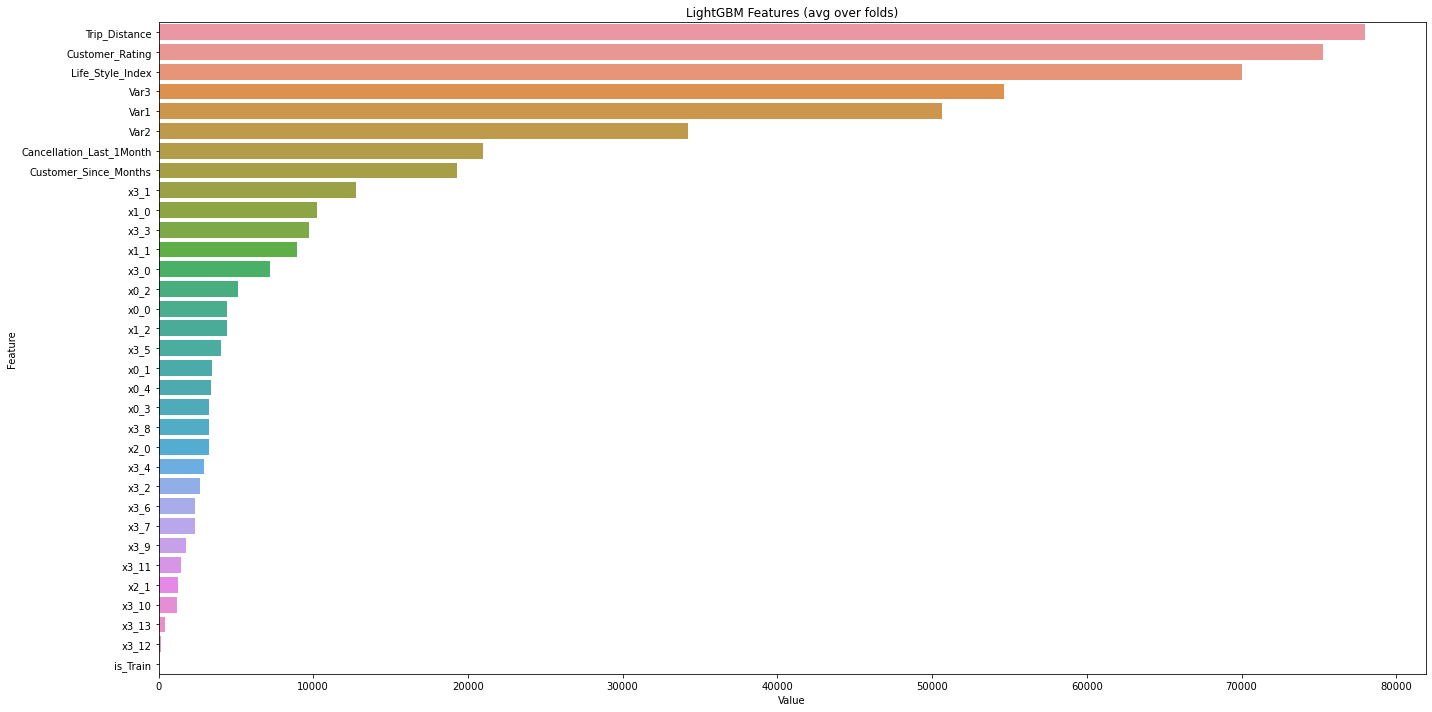

<Figure size 432x288 with 0 Axes>

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(gbm.best_estimator_.feature_importances_,X.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()
plt.savefig('lgbm_importances-01.png')